In [109]:
import matplotlib.pyplot as plt

In [110]:
def pl(s):
    f = open(s)
    r = f.readline()

    chan = []
    val = []

    for i in range(1024):
        c, v = str(f.readline()).split()
        chan.append(int(c))
        val.append(int(v))

    return chan, val

# Analysis of 690v Co data for calibration

In [144]:
dataset = dict()

for i in range(642,744,6):
    chan, val = pl("Co_300_"+str(i)+"v.txt")
    dataset[i] = list(val)
    
calib, valc = pl("Co_600_1.txt")
calib1, valc1 = pl("Cs_600_1.txt")

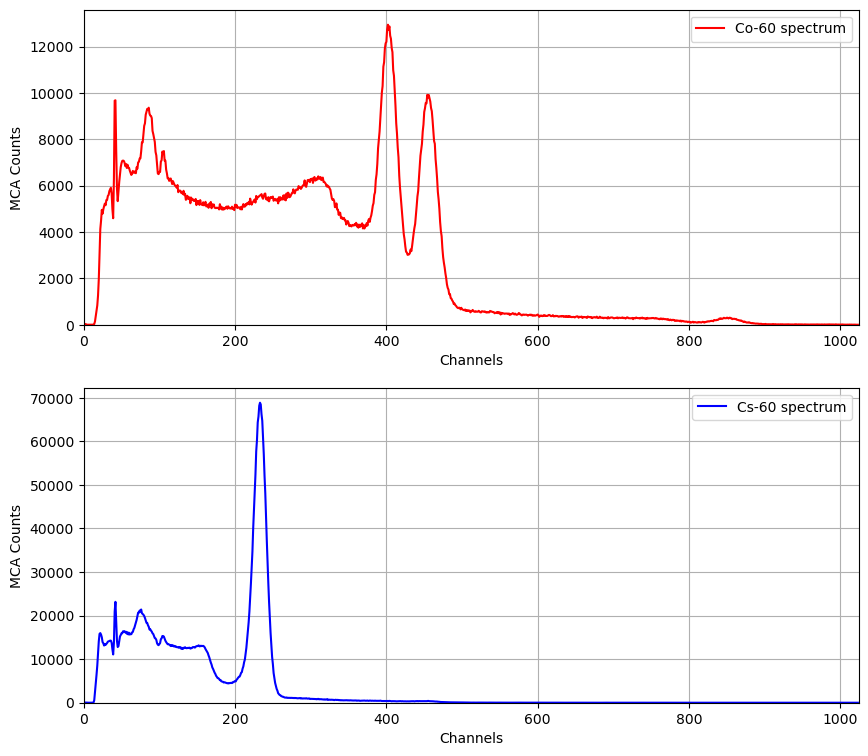

In [158]:
fig,axes= plt.subplots(2,1,figsize=(10,9))
axes[0].plot(calib,valc,label="Co-60 spectrum",color="red")
axes[1].plot(calib1,valc1,label="Cs-60 spectrum",color="b")
axes[0].legend()
axes[1].legend()
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].set_xlim([0,1024])
axes[1].set_xlim([0,1024])
axes[0].grid()
axes[1].grid()

for ax in fig.get_axes():
    ax.set_xlabel("Channels")
    ax.set_ylabel("MCA Counts")
    
fig.savefig("MCA Data", dpi=600)


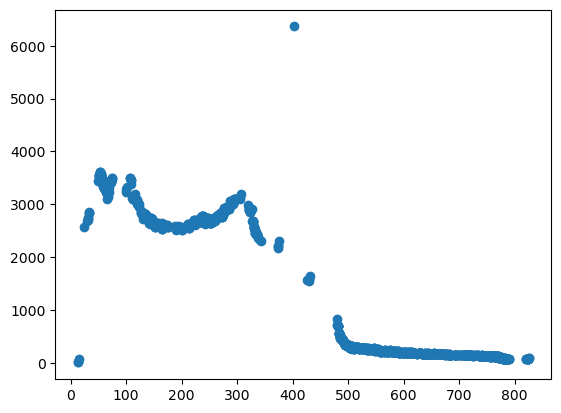

In [131]:
def find_extrema(data,ran):
    extrema = []
    if ran>len(data)//2:
        return False
    else:
        c = ran
        while c < len(data)-ran:
            behind = data[c-ran:c-1]
            front = data[c+1:c+ran]
            sum_behind = 0
            sum_front = 0
            for i in range(ran-1):
                sum_behind += data[c]-behind[i]
                sum_front += -(front[i]-data[c])
            if sum_front*sum_behind < 0:
                extrema.append(c)
                c += 1
            else:
                c += 1
                continue
        return extrema

def dynamic_extrema(data,noise=50):
    extrema = []
    rans = []
    iss = []
    for i in range(0,len(data)-50):
        s = 0
        for k in range(i-1,i+1):
            sl = abs(data[k+1]-data[k])
            if sl <= noise:
                continue
            else:
                s += sl
        slope = s//20
        if slope == 0:
            slope = 1
        ran = 50//(slope**2)
        rans.append(ran*50)
        iss.append(i)
        ex = find_extrema(data,ran)
        for j in ex:
            if i-1<=j<=i+1:
                extrema.append(j)
    return extrema, rans, iss

def smoother(data):
    n = len(data)
    smooth = []
    for i in range(0,n-3,3):
        av = (data[i]+data[i+2])//2
        smooth.append(data[i])
        smooth.append(av)
        smooth.append(data[i+2])
    return smooth

sm = list(dataset[690])
for i in range(50):
    sm = list(smoother(sm))

ch = list(range(len(sm)))

extrema, ran, iss = dynamic_extrema(sm)

# plt.scatter(ch,sm)

e_val = []
for i in extrema:
    e_val.append(sm[i])

plt.scatter(extrema,e_val)
#plt.plot(iss,rans)

plt.show()

# Fitting of the curves

In [116]:
import numpy as np
from scipy.optimize import curve_fit

In [117]:
def non_lin_double_gauss(x,c1,c2,c3,c4,c5,c6,c7,c8,c9):
    return c8*np.exp(-((x-c1)**2)/c2**2) + c9*np.exp(-((x-c3)**2)/c4**2) + c5*(x**2) + c6*x + c7

def fitting(x,y):
    xdata = np.asarray(x)
    ydata = np.asarray(y)

    parameters, covariance = curve_fit(non_lin_double_gauss, xdata, ydata,p0=[400,1,450,1,0.05,0.01,400,4000,4000])

    return parameters, covariance


In [214]:

# p, c = fitting(chan[370:500],dataset[690][370:500])
p, c = fitting(calib[370:500],valc[370:500])
cerr = np.sqrt(np.diag(c))

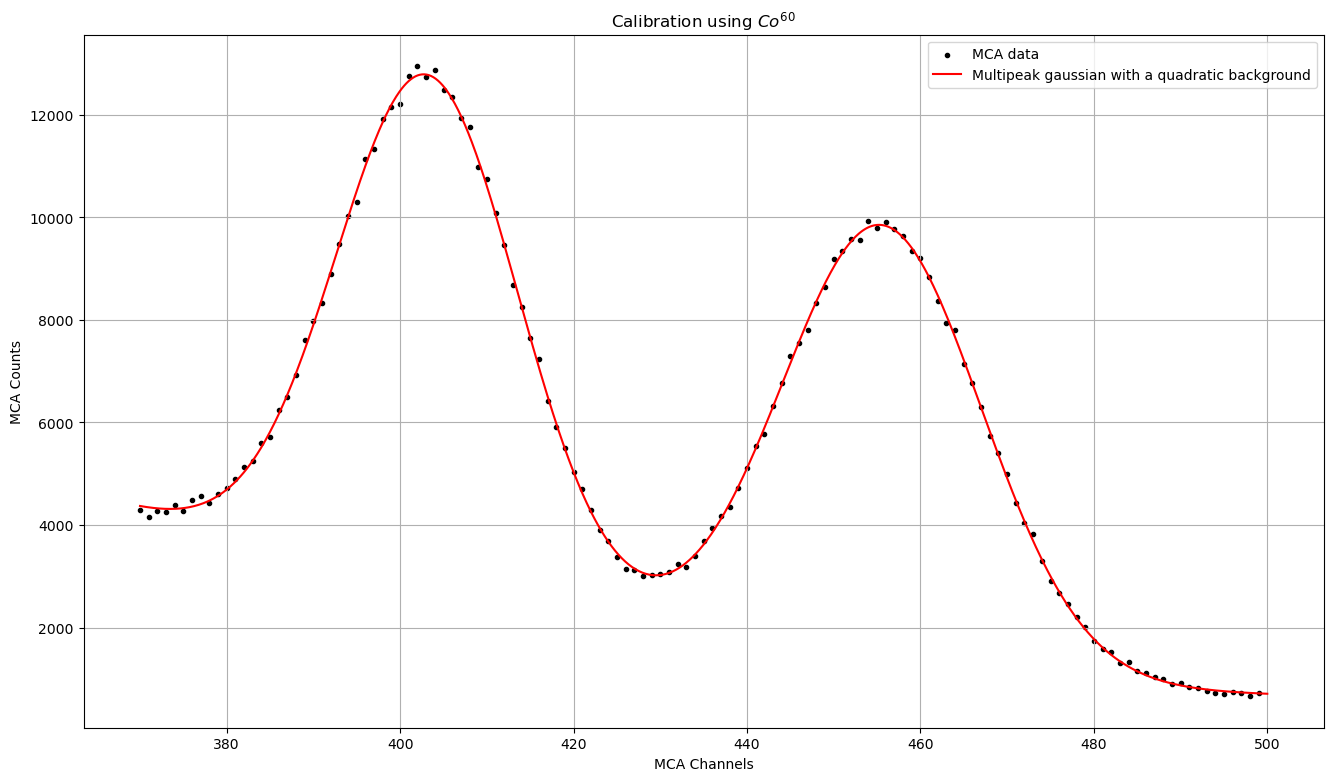

In [160]:
fig,axes = plt.subplots(1,1,figsize=(16,9))
# plt.scatter(chan[370:500],dataset[690][370:500], label="MCA data", marker='.',color='k')
plt.scatter(calib[370:500],valc[370:500], label="MCA data", marker='.',color='k')
xs = np.linspace(370,500,1000)
ys = non_lin_double_gauss(xs,p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8])
plt.plot(xs,ys, label="Multipeak gaussian with a quadratic background",color='r')
plt.legend()
plt.grid()
plt.xlabel("MCA Channels")
plt.ylabel("MCA Counts")
plt.title(r"Calibration using $Co^{60}$")
plt.show()
fig.savefig("cobaltcalib",dpi=600)

In [161]:
print('Centroid 1 -> ',p[0])
print('Centroid 2 -> ',p[2])

Centroid 1 ->  403.1362361046349
Centroid 2 ->  455.5420101995718


In [212]:
energy_unit = (1.1732-1.3325)/(round(p[0])-round(p[2]))
print(energy_unit)

0.0030056603773584907


# Finding the energy of the Cs-137 photopeak

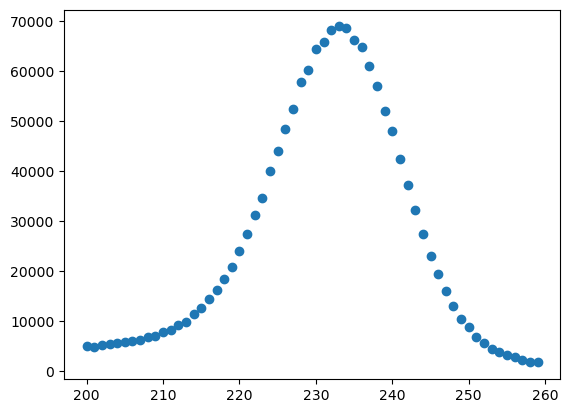

In [12]:
chanCs, valCs = pl("Cs_600_1.txt")

def gauss(x,c1,c2,c3,c4):
    return c1*np.exp(-((x-c2)**2/c3**2)) + c4

plt.scatter(chanCs[200:260],valCs[200:260])
plt.show()

232.62320813272842 0.08314986604564074


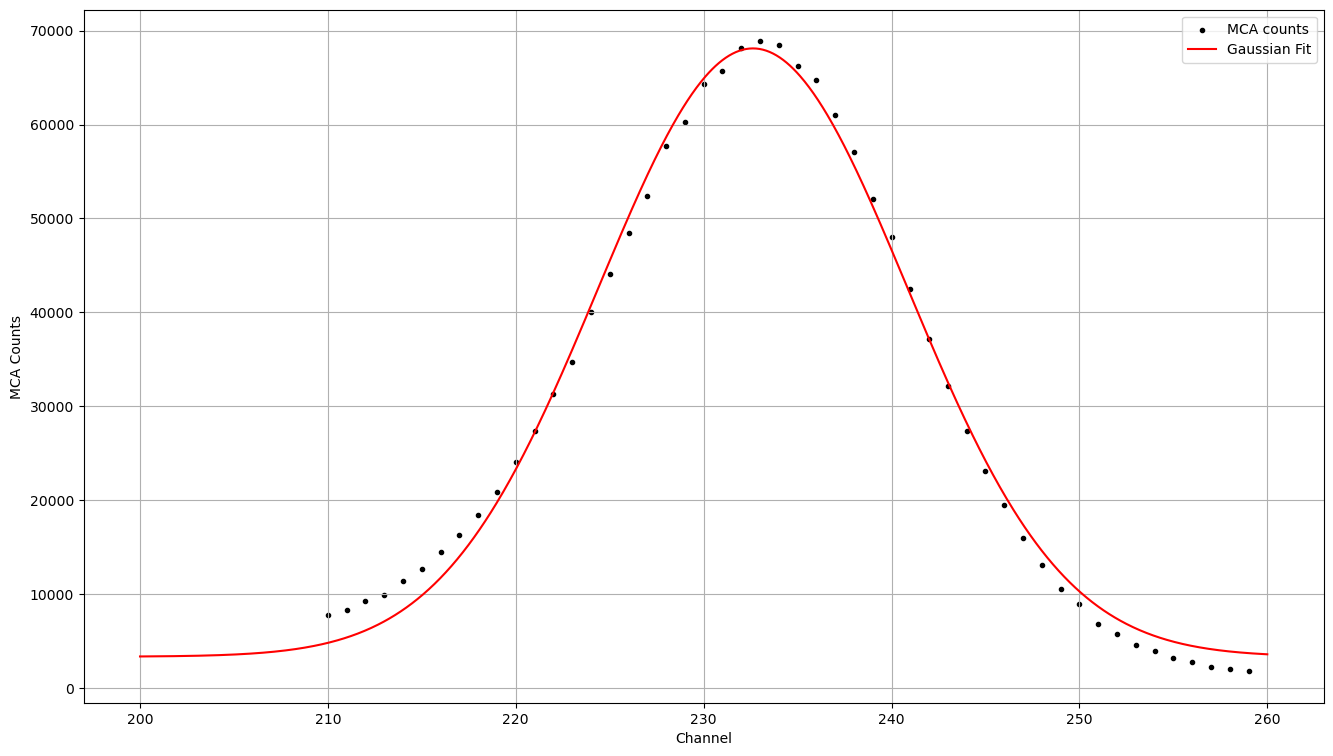

In [219]:

fig,axes= plt.subplots(1,1,figsize=(16,9))
xdata = np.asarray(chanCs[210:260])
ydata = np.asarray(valCs[210:260])

pa, cov = curve_fit(gauss, xdata, ydata, p0=[6000,237,20,0])
perr= np.sqrt(np.diag(cov))
plt.scatter(xdata,ydata,label="MCA counts", marker='.', color="k")
xs = np.linspace(200,260,1000)
ys = gauss(xs,pa[0],pa[1],pa[2],pa[3])
plt.plot(xs,ys, label="Gaussian Fit", color='r')
plt.legend()
plt.grid()
print(pa[1], perr[1])
plt.xlabel("Channel")
plt.ylabel("MCA Counts")
plt.show()

fig.savefig("CesiumEnergy",dpi=600)

In [217]:
print("energy of the Cs-137 photopeak -> ", 0.003*pa[1])

energy of the Cs-137 photopeak ->  0.6978696243981852


### close enough nigga - actual value is around 0.662

# Calculation of photopeak efficiency at 690v PMT

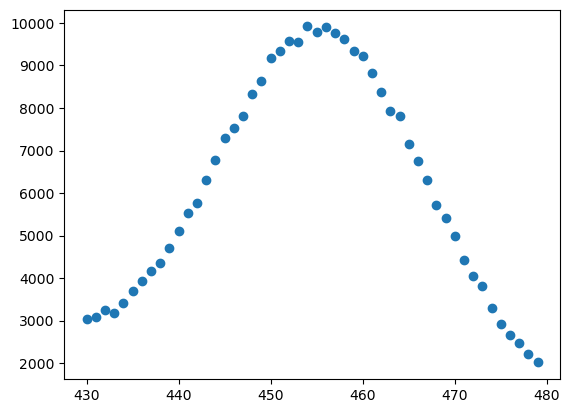

In [168]:
p1_chan = calib[370:430]
p1_val = valc[370:430]

p2_chan = calib[430:480]
p2_val = valc[430:480]

plt.scatter(p2_chan,p2_val)

In [169]:
total_counts = sum(dataset[690])
p1_count = sum(p1_val)
p2_count = sum(p2_val)

print('Photopeak efficiency for peak 1 -> ',(p1_count/total_counts)*100,"%")
print('Photopeak efficiency for peak 2 -> ',(p2_count/total_counts)*100,"%")

Photopeak efficiency for peak 1 ->  30.595068532418786 %
Photopeak efficiency for peak 2 ->  21.242534683102594 %


# Calculation of the resolution vs PMT voltage
You better thank me for this nigga

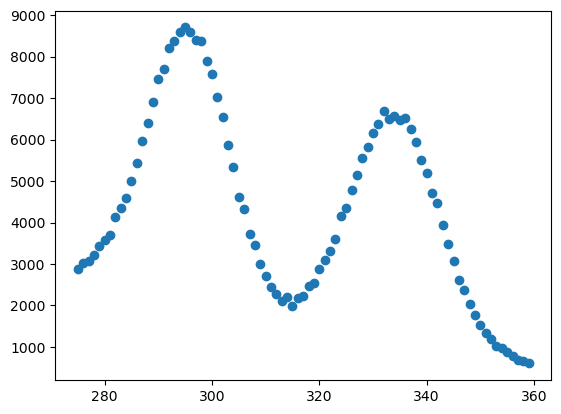

In [21]:
cut1 = 275
cut2 = 360
plt.scatter(chan[cut1:cut2],dataset[654][cut1:cut2])
plt.show()

In [25]:
cutoff = [(250,290,325),(260,300,340),(275,315,355),(295,335,380),(305,350,390),(325,370,420),(340,390,440),(355,405,460),(370,425,480),(395,450,510),(415,475,535),(440,500,560),(470,540,610),(490,560,630),(510,585,670),(535,610,695),(565,645,730)]
print("If this data is off I'm offing myself")

If this data is off I'm offing myself


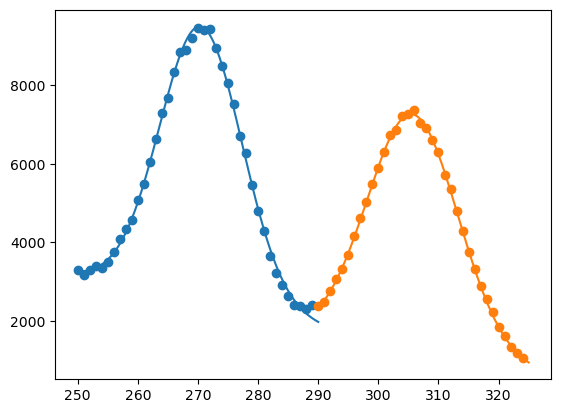

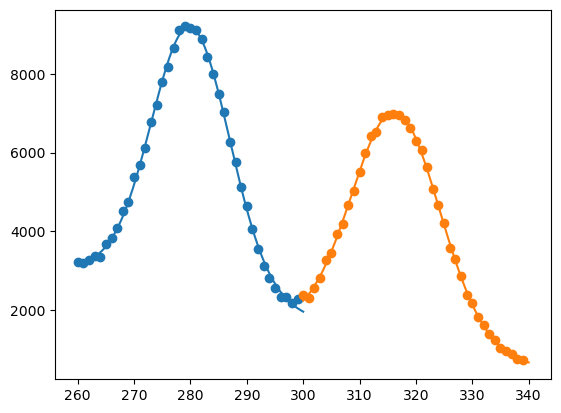

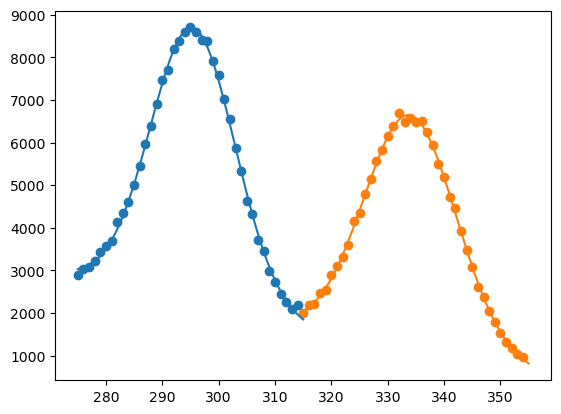

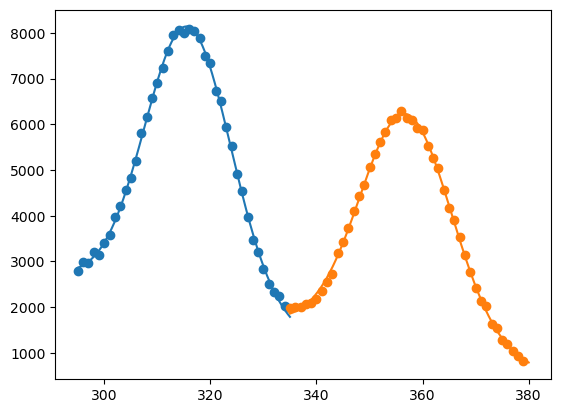

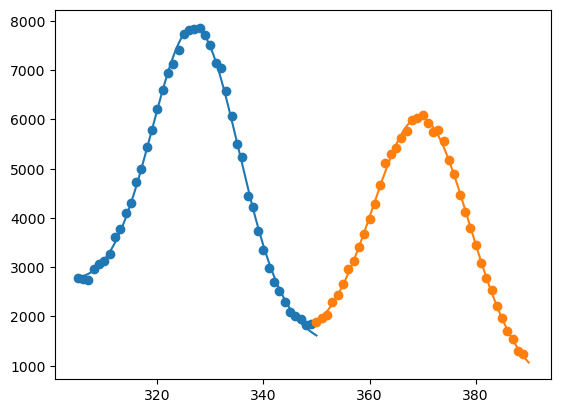

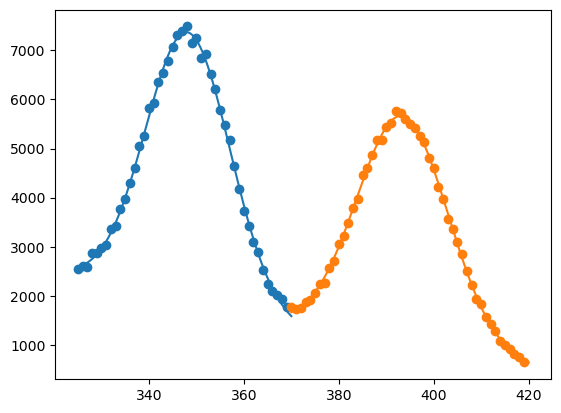

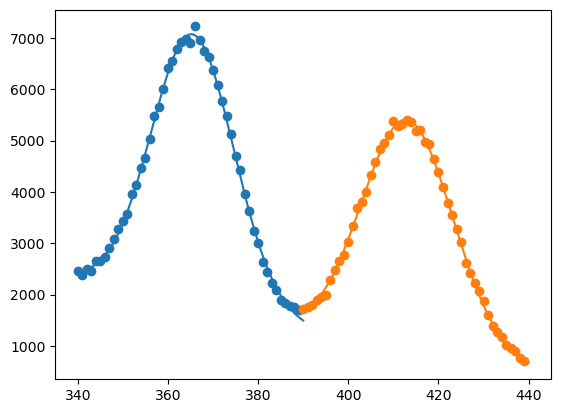

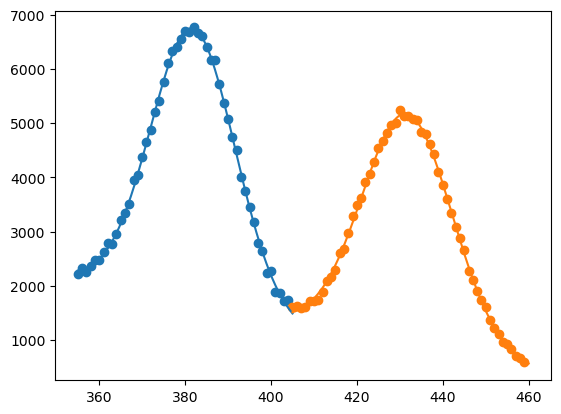

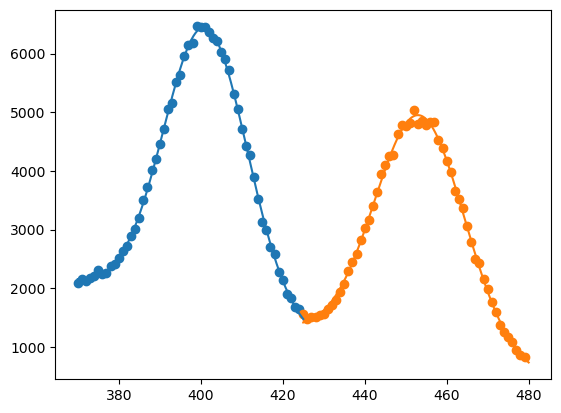

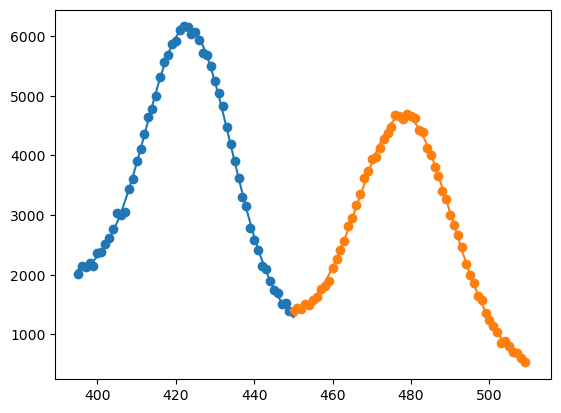

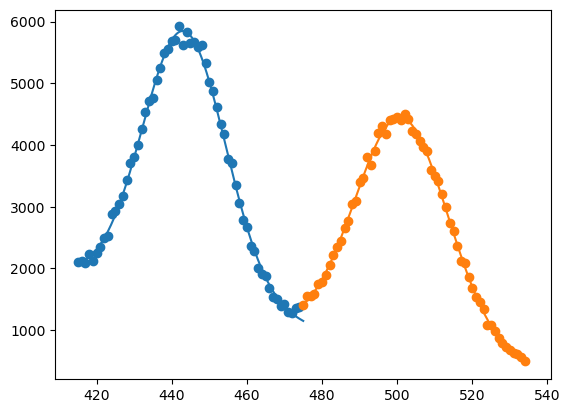

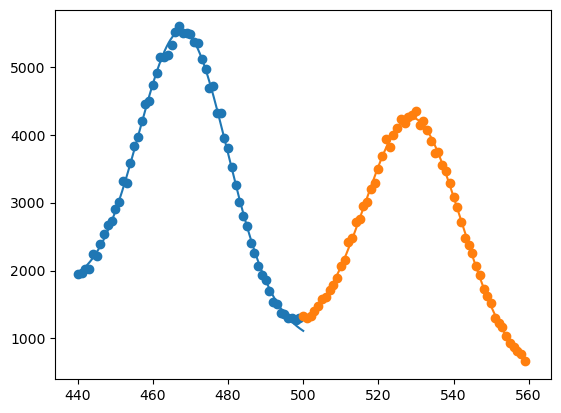

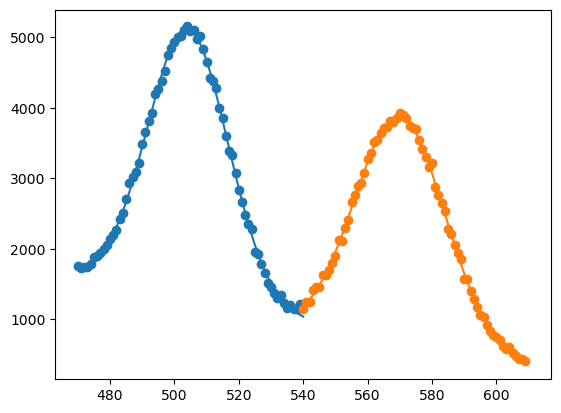

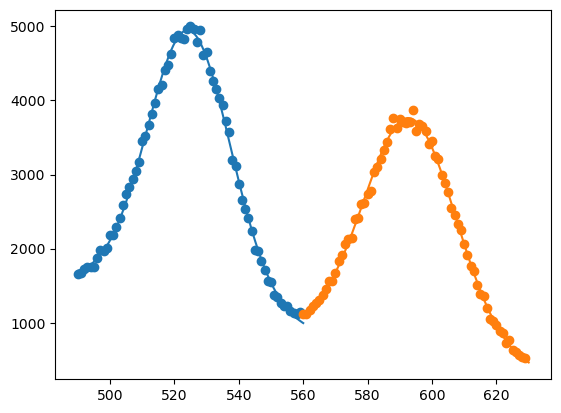

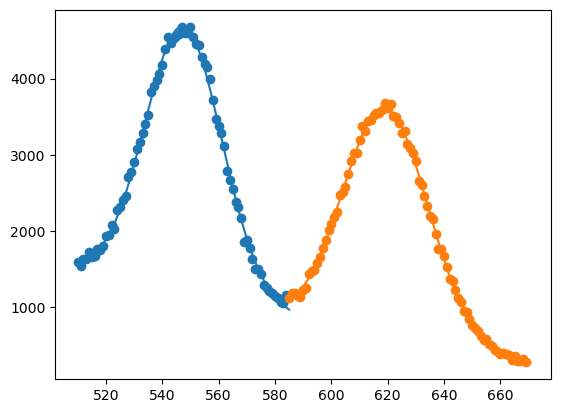

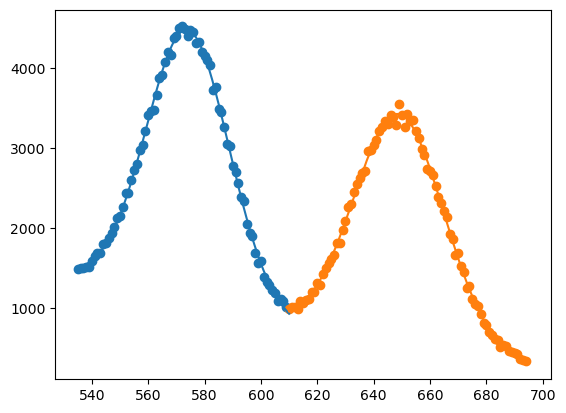

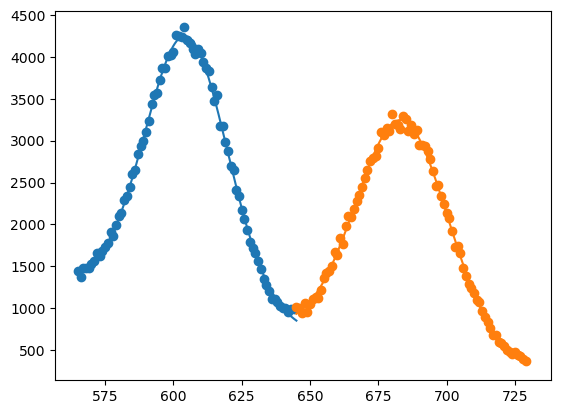

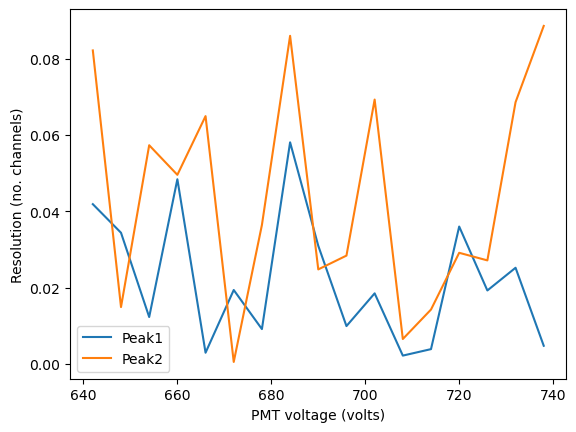

In [23]:
c = 0
res1 = []
res2 = []
pmt = []

def non_lin_gauss(x,c1,c2,c3,c4,c5):
    return c1*np.exp(-((x-c2)**2/c3**2)) + c4*(x**2) + c5

for i in dataset.keys():
    p1_data = dataset[i][cutoff[c][0]:cutoff[c][1]]
    p2_data = dataset[i][cutoff[c][1]:cutoff[c][2]]
    p1_chan = chan[cutoff[c][0]:cutoff[c][1]]
    p2_chan = chan[cutoff[c][1]:cutoff[c][2]]
    p1_peak_guess = round((cutoff[c][0]+cutoff[c][1])/2)
    p2_peak_guess = round((cutoff[c][1]+cutoff[c][2])/2)
    p1_height_guess = dataset[i][p1_peak_guess]-dataset[i][cutoff[c][0]]
    p2_height_guess = dataset[i][p2_peak_guess]-dataset[i][cutoff[c][1]]

    xdata1 = np.asarray(p1_chan)
    ydata1 = np.asarray(p1_data)

    par1, cova1 = curve_fit(non_lin_gauss,xdata1,ydata1,p0=[p1_height_guess,p1_peak_guess,20,0.05,0])

    xdata2 = np.asarray(p2_chan)
    ydata2 = np.asarray(p2_data)

    par2, cova2 = curve_fit(non_lin_gauss,xdata2,ydata2,p0=[p2_height_guess,p2_peak_guess,20,0.05,0])  

    xs1 = np.linspace(cutoff[c][0],cutoff[c][1],1000)
    xs2 = np.linspace(cutoff[c][1],cutoff[c][2],1000)
    ys1 = non_lin_gauss(xs1,par1[0],par1[1],par1[2],par1[3],par1[4])
    ys2 = non_lin_gauss(xs2,par2[0],par2[1],par2[2],par2[3],par2[4])
    plt.scatter(xdata1,ydata1)
    plt.scatter(xdata2,ydata2)
    plt.plot(xs1,ys1)
    plt.plot(xs2,ys2)
    plt.show()
    pmt.append(i)

    ce1 = round(par1[1])
    ce2 = round(par2[1])
    
    e1 = dataset[i][ce1]
    e2 = dataset[i][ce2]

    fwhm1 = par1[2]
    fwhm2 = par2[2]

    de1 = abs(dataset[i][round(ce1-(fwhm1/2))] - dataset[i][round(ce1+(fwhm1/2))])
    de2 = abs(dataset[i][round(ce2-(fwhm2/2))] - dataset[i][round(ce2+(fwhm2/2))])
    
    res1.append(de1/e1)
    res2.append(de2/e2)
    c+=1

plt.plot(pmt,res1,label='Peak1')
plt.plot(pmt,res2,label='Peak2')
plt.xlabel("PMT voltage (volts)")
plt.ylabel("Resolution (no. channels)")
plt.legend()
plt.show()

If this data is off I'm offing myself


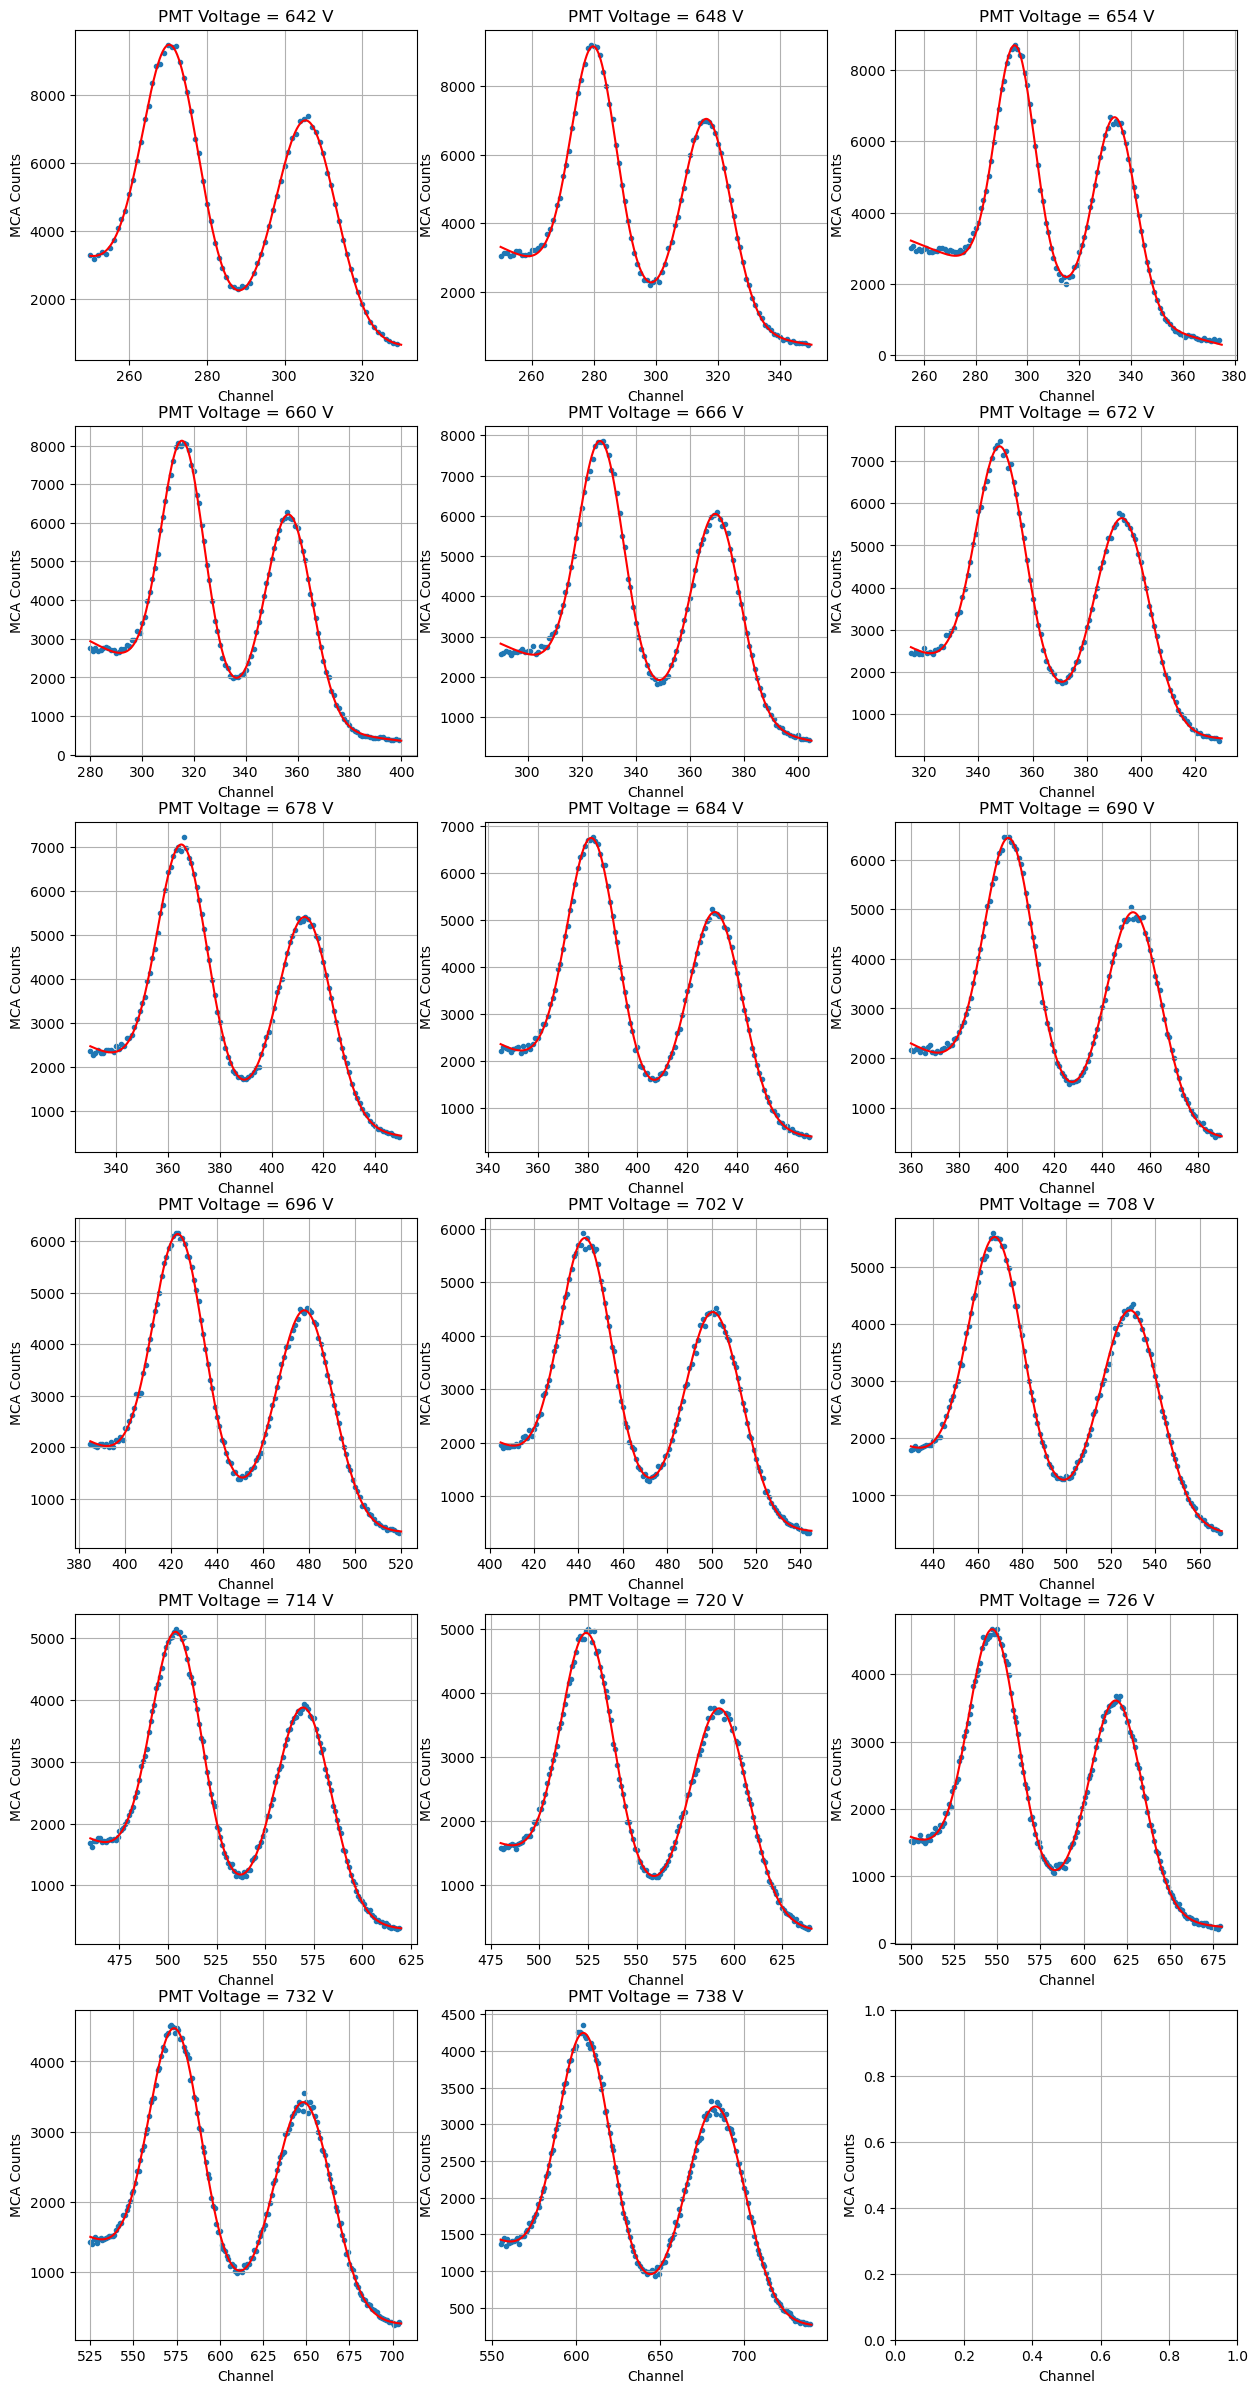

In [215]:
cutoff = [(260,290,320),(260,300,340),(265,315,365),(290,335,390),(300,350,395),(325,370,420),(340,390,440),(355,405,460),(370,425,480),(395,450,510),(415,475,535),(440,500,560),(470,540,610),(490,560,630),(510,585,670),(535,610,695),(565,645,730)]
print("If this data is off I'm offing myself")
c = 0
res1 = []
res2 = []
pmt = []
fig,axes=plt.subplots(6,3,figsize=(15,30))
d=0
for i in range(642,744,6):
    p1_data = dataset[i][cutoff[c][0]:cutoff[c][1]]
    p2_data = dataset[i][cutoff[c][1]:cutoff[c][2]]
    p1_chan = chan[cutoff[c][0]:cutoff[c][1]]
    p2_chan = chan[cutoff[c][1]:cutoff[c][2]]
    p1_peak_guess = round((cutoff[c][0]+cutoff[c][1])/2)
    p2_peak_guess = round((cutoff[c][1]+cutoff[c][2])/2)
    p1_height_guess = dataset[i][p1_peak_guess]-dataset[i][cutoff[c][0]]
    p2_height_guess = dataset[i][p2_peak_guess]-dataset[i][cutoff[c][1]]
    total_data = dataset[i][cutoff[c][0]-10:cutoff[c][2]+10]
    total_chan = chan[cutoff[c][0]-10:cutoff[c][2]+10]

    xdata = np.asarray(total_chan)
    ydata = np.asarray(total_data)

    par, cova = curve_fit(non_lin_double_gauss, xdata, ydata, p0=[p1_peak_guess,20,p2_peak_guess,20,0.05,0.01,0,p1_height_guess,p2_height_guess],maxfev=1000000)

    xs = np.linspace(cutoff[c][0]-10,cutoff[c][2]+10,10000)
    ys = non_lin_double_gauss(xs,par[0],par[1],par[2],par[3],par[4],par[5],par[6],par[7],par[8])
    
    if c%3 == 0:
        axes[d][0].scatter(xdata,ydata, marker='.')
        axes[d][0].set_title("PMT Voltage = " + str(i) +" V")

        axes[d][0].plot(xs,ys, color="r")
    elif (c)%3 == 1:
        axes[d][1].scatter(xdata,ydata, marker='.')
        axes[d][1].set_title("PMT Voltage = " + str(i) +" V")
        axes[d][1].plot(xs,ys, color='r')
    elif (c)%3==2:
        axes[d][2].scatter(xdata,ydata, marker='.')
        axes[d][2].set_title("PMT Voltage = " + str(i) +" V")
        axes[d][2].plot(xs,ys, color='r')
        d+=1
    
    # if d==2:
    #     d=-1
    
    pmt.append(i)

    ce1 = round(par[0])
    ce2 = round(par[2])
    
    e1 = dataset[i][ce1]
    e2 = dataset[i][ce2]

    fwhm1 = 2*np.sqrt(np.log(2))*par[1]
    fwhm2 = 2*np.sqrt(np.log(2))*par[3]

    de1 = abs(dataset[i][round(ce1-(fwhm1/2))] - dataset[i][round(ce1+(fwhm1/2))])
    de2 = abs(dataset[i][round(ce2-(fwhm2/2))] - dataset[i][round(ce2+(fwhm2/2))])
    
    res1.append(de1/e1)
    res2.append(de2/e2)
    c+=1

for ax in fig.get_axes():
    ax.grid()
    ax.set_xlabel("Channel")
    ax.set_ylabel("MCA Counts")
    
fig.savefig("PMTvariation", dpi = 600)

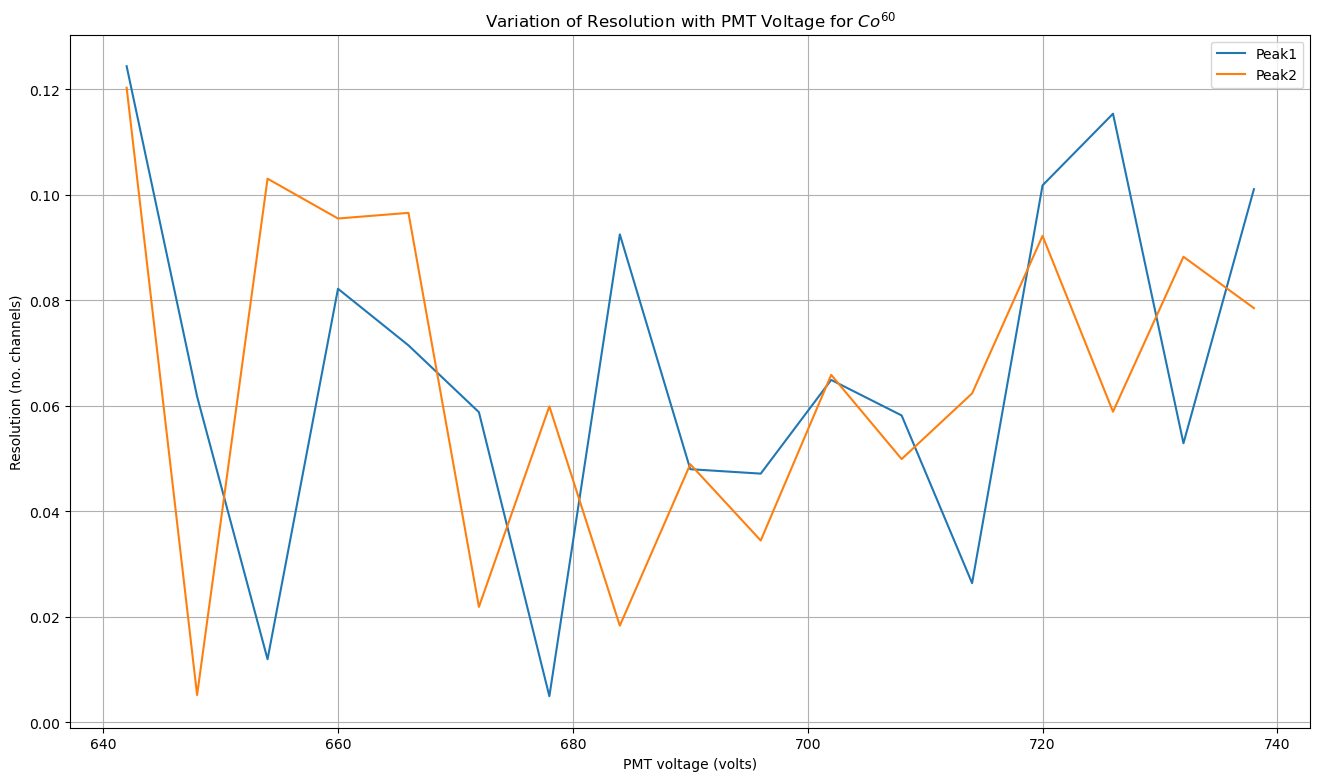

In [216]:
fig,axes = plt.subplots(1,1,figsize=(16,9))
axes.plot(pmt,res1,label='Peak1')
axes.plot(pmt,res2,label='Peak2')
axes.set_xlabel("PMT voltage (volts)")
axes.set_ylabel("Resolution (no. channels)")
axes.legend()
axes.set_title(r"Variation of Resolution with PMT Voltage for $Co^{60}$")
axes.grid()
fig.savefig("PMTreso", dpi=600)